In [1]:
%history

%history


In [1]:
import torch
import torch.nn as nn   


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
# Create DataLoader for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
test_iter = iter(test_loader)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Images shape: torch.Size([8, 3, 256, 256])
Labels shape: torch.Size([8])
horse


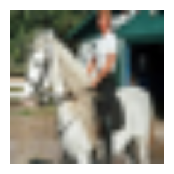

In [25]:
#CIFAR labels to human readable labels
CIFAR10_CLASSES = [
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
data = next(test_iter)
images, labels = data

# Check the shape of the images and labels
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

#decode the first image
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(2, 2))  # keep this small to avoid blur
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')  # no interpolation
    plt.axis('off')
    plt.show()
print(CIFAR10_CLASSES[labels[0].item()])
imshow(images[0])

In [5]:
from torch.optim.lr_scheduler import CosineAnnealingLR

#create patch of image

def splitBatch(images):
    B,C,H,W = images.shape
    patch_size = 16

    y = []

    for i in range(H//(patch_size)):
        for j in range(W//patch_size):
            x = images[:,:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]
            x = x.reshape(B,-1)
            y.append(x)

    y = torch.stack(y,dim=1)

    return y

import  torch.nn.functional as F
class MultiHeadAttn(nn.Module):
    def __init__(self,num_head=4,embedding_dim=588):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_head = num_head
        self.head_dim = embedding_dim//num_head
    
        self.linear = nn.Linear(embedding_dim,3*embedding_dim)
        self.out_proj = nn.Linear(embedding_dim,embedding_dim)
        


    
    def forward(self,x):
        #x-> B,Context_length,embedding_dim
        B,C,T = x.shape
        kqv = self.linear(x) #B,Context length,3*embedding dim
        kqv = kqv.reshape(B,C,3,self.num_head,self.head_dim)
        kqv = kqv.permute(2,3,0,1,4)
        k,q,v = kqv[0],kqv[1],kqv[2] #head,B,C,T/head
        attn = (q@(k.transpose(3,2)))/(self.head_dim)**0.5 #head,B,C,C
        attn = F.softmax(attn,dim=-1) # head,B,C,C
        y = attn @ v # head,B,C,T/head
        y = y.permute(1,2,0,3) #B,C,C,T/Head
        y = y.reshape(B,C,-1)
        return self.out_proj(y)

class MLP(nn.Module):
    def __init__(self,embedding_dim):
        super().__init__()
        self.linear1 = nn.Linear(embedding_dim,4*embedding_dim)
        self.relu = nn.GELU()
        self.linear2 = nn.Linear(4*embedding_dim,embedding_dim)
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x



class Transformer(nn.Module):
    def __init__(self,num_head=4,embedding_dim=588):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embedding_dim)
        self.mha = MultiHeadAttn(num_head,embedding_dim)
        self.layer_norm_2 = nn.LayerNorm(embedding_dim)
        self.mlp = MLP(embedding_dim)
    

    def forward(self,x):
        residual = x.clone()
        x = self.layer_norm_1(x)
        x = self.mha(x)
        x = x+residual
        residual = x.clone()
        x = self.layer_norm_2(x)
        x = self.mlp(x)
        x = x + residual
        return x

class VIT(nn.Module):
    def __init__(self,layer_num = 12,patch_size=14,channels = 3,context_length=196,embedding_dim = 588,num_attn_head = 8,class_size=10):
        super(VIT,self).__init__()
        self.context_length = context_length
        self.LinearProj = nn.Linear(in_features=patch_size*patch_size*channels,out_features=embedding_dim)
        self.embedding = nn.Embedding(num_embeddings=1,embedding_dim=embedding_dim)
        self.pos_embedding = nn.Embedding(num_embeddings=context_length+1,embedding_dim=embedding_dim)
        self.encoder_blocks = nn.ModuleList([Transformer(num_head = num_attn_head,embedding_dim=embedding_dim) for i in range(layer_num)])
        self.mlp = MLP(embedding_dim)
        self.class_proj = nn.Linear(embedding_dim,10)


        
    

    def forward(self,image):
        #image---> (B,context_length,P*P*3)
        B,C,feature_size = image.shape
        x = self.LinearProj(image)
        cls_token = self.embedding(torch.tensor([0],device='cuda'))
        cls_token = cls_token.unsqueeze(0).expand(B, 1, -1)  # [64, 1, 768]
        x = torch.cat([cls_token,x],dim=1) 
        pos = torch.arange(0,self.context_length+1).to(device='cuda')
        pos_ = self.pos_embedding(pos)
        x = x + self.pos_embedding(pos)  
        for enc in self.encoder_blocks:
            x = enc(x)
        
        x = self.mlp(x)

        cls_em = self.class_proj(x[:,0])

        return cls_em

#vit  = VIT(layer_num=8,patch_size=16,channels=3,context_length=256,embedding_dim=768,num_attn_head=8,class_size=10).to('cuda')
# optimizer = torch.optim.Adam(params=vit.parameters(),lr = 1e-3)

# print(len(train_loader))
# print(len(train_dataset))
# num_epoch = 3
# num_grad_accum=16
# total_loss = 0

# scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * num_epoch)  # full schedule over all steps

# for epoch in range(num_epoch):
#     for i, (images, labels) in enumerate(iter(train_loader)):
#         images = images.to('cuda')
#         patches = splitBatch(images)
#         y = vit(patches)
#         labels = labels.to('cuda')
#         loss = F.cross_entropy(y,labels)/num_grad_accum
#         total_loss+=loss.item()
#         loss.backward()
#         if(i%num_grad_accum==1):
#             optimizer.step()
#             optimizer.zero_grad()
#             scheduler.step()  # step after every optimizer update

            
#         if(i%num_grad_accum==1):
#             print(f"\rEpoch {epoch}, Step {i+1}/{len(train_loader)} - Loss: {total_loss:.4f}, Acc: {acc:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}", end='')
#             total_loss=0 


In [12]:

vit.train()
num_epoch=30
optimizer = torch.optim.Adam(params=vit.parameters(),lr = 1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * num_epoch)  # full schedule over all steps


for epoch in range(num_epoch):
    torch.save(vit.state_dict(),f'vit_{epoch}.pth')
    for i, (images, labels) in enumerate(train_loader):
        images = images.to('cuda')
        labels = labels.to('cuda')
        patches = splitBatch(images)

        y = vit(patches)
        loss = F.cross_entropy(y, labels) / num_grad_accum
        total_loss += loss.item()
        loss.backward()

        if (i + 1) % num_grad_accum == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
            print(f"\rEpoch {epoch}, Step {i+1}/{len(train_loader)} - Loss: {total_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}", end='')
            total_loss = 0


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 0, Step 6240/6250 - Loss: 1.7447, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 1, Step 6240/6250 - Loss: 1.5245, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 2, Step 6240/6250 - Loss: 1.7042, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 3, Step 6240/6250 - Loss: 1.6952, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 4, Step 6240/6250 - Loss: 1.3948, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 5, Step 6240/6250 - Loss: 1.5224, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 6, Step 6240/6250 - Loss: 1.5751, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 7, Step 6240/6250 - Loss: 1.3357, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 8, Step 6240/6250 - Loss: 1.4030, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 9, Step 6240/6250 - Loss: 1.3264, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 10, Step 6240/6250 - Loss: 1.3938, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 11, Step 6240/6250 - Loss: 1.3627, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 12, Step 6240/6250 - Loss: 1.2044, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 13, Step 6240/6250 - Loss: 1.0216, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 14, Step 6240/6250 - Loss: 1.0849, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 15, Step 6240/6250 - Loss: 1.3154, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 16, Step 6240/6250 - Loss: 0.9966, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 17, Step 6240/6250 - Loss: 1.1600, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 18, Step 6240/6250 - Loss: 0.9875, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 19, Step 6240/6250 - Loss: 0.9542, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 20, Step 6240/6250 - Loss: 0.9523, LR: 0.000100

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 21, Step 6240/6250 - Loss: 1.0348, LR: 0.000099

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 22, Step 6240/6250 - Loss: 0.7826, LR: 0.000099

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 23, Step 6240/6250 - Loss: 0.8142, LR: 0.000099

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 24, Step 6240/6250 - Loss: 0.7317, LR: 0.000099

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 25, Step 6240/6250 - Loss: 0.6582, LR: 0.000099

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 26, Step 6240/6250 - Loss: 0.5478, LR: 0.000099

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 27, Step 6240/6250 - Loss: 0.4530, LR: 0.000099

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 28, Step 6240/6250 - Loss: 0.3743, LR: 0.000099

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch 29, Step 6240/6250 - Loss: 0.3984, LR: 0.000099

In [ ]:
vit  = VIT(layer_num=8,patch_size=16,channels=3,context_length=256,embedding_dim=768,num_attn_head=8,class_size=10)

vit.load_state_dict(torch.load("vit_29.pth"))
vit.to('cuda')

@torch.no_grad()
def inference():
    vit.eval()
    correctly_labeled = 0
    total_images = 0
    for images,labels in train_loader:
        total_images  += images.shape[0]
        images = images.to('cuda')
        patches = splitBatch(images)
        y = vit(patches)
        labels = labels.to('cuda')
        preds = torch.argmax(y, dim=1)
        correctly_labeled += (preds == labels).sum().item()
        print("acc:",correctly_labeled/total_images)
inference()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

acc: 1.0
acc: 1.0
acc: 1.0
acc: 0.96875
acc: 0.975
acc: 0.9791666666666666
acc: 0.9821428571428571
acc: 0.984375
acc: 0.9861111111111112
acc: 0.9875
acc: 0.9886363636363636
acc: 0.9895833333333334
acc: 0.9807692307692307
acc: 0.9821428571428571
acc: 0.975
acc: 0.96875
acc: 0.9705882352941176
acc: 0.9652777777777778
acc: 0.9671052631578947
acc: 0.96875
acc: 0.9642857142857143
acc: 0.9659090909090909
acc: 0.967391304347826
acc: 0.9635416666666666
acc: 0.955
acc: 0.9567307692307693
acc: 0.9583333333333334
acc: 0.9553571428571429
acc: 0.9568965517241379
acc: 0.9583333333333334
acc: 0.9596774193548387
acc: 0.9609375
acc: 0.9621212121212122
acc: 0.9558823529411765
acc: 0.9571428571428572
acc: 0.9583333333333334
acc: 0.956081081081081
acc: 0.9539473684210527
acc: 0.9551282051282052
acc: 0.95625
acc: 0.9542682926829268
acc: 0.9494047619047619
acc: 0.9476744186046512
acc: 0.9488636363636364
acc: 0.95
acc: 0.9510869565217391
acc: 0.9521276595744681
acc: 0.953125
acc: 0.9489795918367347
acc: 0.95

KeyboardInterrupt: 